# Activation Maximization on MNIST

Lets build the mnist model and train it for 5 epochs. It should get to about ~99% test accuracy.

In [20]:
from __future__ import print_function

import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='preds'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s - loss: 0.2346 - acc: 0.9279 - val_loss: 0.0552 - val_acc: 0.9817
Epoch 2/5
60000/60000 [==============================] - 5s - loss: 0.0845 - acc: 0.9756 - val_loss: 0.0363 - val_acc: 0.9881
Epoch 3/5
60000/60000 [==============================] - 5s - loss: 0.0620 - acc: 0.9819 - val_loss: 0.0336 - val_acc: 0.9897
Epoch 4/5
60000/60000 [==============================] - 5s - loss: 0.0533 - acc: 0.9839 - val_loss: 0.0317 - val_acc: 0.9895
Epoch 5/5
60000/60000 [==============================] - 5s - loss: 0.0436 - acc: 0.9865 - val_loss: 0.0295 - val_acc: 0.9910
Test loss: 0.0295144059571
Test accuracy: 0.991


## Dense Layer Visualizations

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear' and compare what happens if we dont do this at the end.

Lets start by visualizing input that maximizes the output of node 0. Hopefully this looks like a 0.

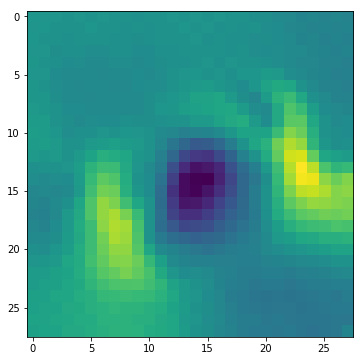

In [21]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])

Hmm, it sort of looks like a 0, but not as clear as we hoped for. Activation maximization is notorious because regularization parameters needs to be tuned depending on the problem. Lets enumerate all the possible reasons why this didn't work very well.
    
- The input to network is preprocessed to range (0, 1). We should specify `input_range = (0., 1.)` to constrain the input to this range.
- The regularization parameter default weights might be dominating activation maximization loss weight. One way to debug this is to use `verbose=True` and examine individual loss values.

Lets do these step by step and see if we can improve it.

### Debugging step 1: Specifying input_range

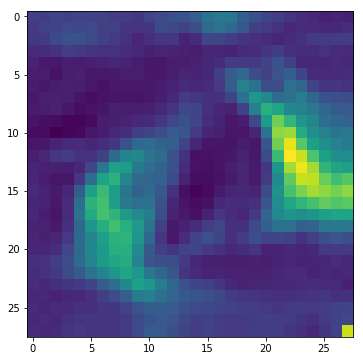

In [22]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.))
plt.imshow(img[..., 0])

Much better but still seems noisy. Lets examining the losses with `verbose=True` and tuning the weights.

### Debugging step 2: Tuning regularization weights

One of the issues with activation maximization is that the input can go out of the training distribution space. Total variation and L-p norm are used to provide some hardcoded image priors for natural images. For example, Total variation ensures that images are blobber and not scattered. Unfotunately, sometimes these losses can dominate the main `ActivationMaximization` loss.

Lets see what individual losses are, with `verbose=True`

Iteration: 1, named_losses: [('ActivationMax Loss', 0.085303515),
 ('L-6.0 Norm Loss', 0.019828862),
 ('TV(2.0) Loss', 0.095951974)], overall loss: 0.201084345579
Iteration: 2, named_losses: [('ActivationMax Loss', -2.3290093),
 ('L-6.0 Norm Loss', 0.17779008),
 ('TV(2.0) Loss', 507.10727)], overall loss: 504.956054688
Iteration: 3, named_losses: [('ActivationMax Loss', -128.49548),
 ('L-6.0 Norm Loss', 0.19667891),
 ('TV(2.0) Loss', 164.45709)], overall loss: 36.1582946777
Iteration: 4, named_losses: [('ActivationMax Loss', -250.48241),
 ('L-6.0 Norm Loss', 0.19896419),
 ('TV(2.0) Loss', 178.49908)], overall loss: -71.784362793
Iteration: 5, named_losses: [('ActivationMax Loss', -355.06989),
 ('L-6.0 Norm Loss', 0.23281187),
 ('TV(2.0) Loss', 168.41599)], overall loss: -186.421081543
Iteration: 6, named_losses: [('ActivationMax Loss', -434.47665),
 ('L-6.0 Norm Loss', 0.27569067),
 ('TV(2.0) Loss', 198.10806)], overall loss: -236.092895508
Iteration: 7, named_losses: [('ActivationMax 

Iteration: 92, named_losses: [('ActivationMax Loss', -1597.2491),
 ('L-6.0 Norm Loss', 1.3033614),
 ('TV(2.0) Loss', 783.2879)], overall loss: -812.657897949
Iteration: 93, named_losses: [('ActivationMax Loss', -1593.3665),
 ('L-6.0 Norm Loss', 1.3075004),
 ('TV(2.0) Loss', 779.44653)], overall loss: -812.612426758
Iteration: 94, named_losses: [('ActivationMax Loss', -1597.2029),
 ('L-6.0 Norm Loss', 1.3099935),
 ('TV(2.0) Loss', 781.82526)], overall loss: -814.067687988
Iteration: 95, named_losses: [('ActivationMax Loss', -1597.9543),
 ('L-6.0 Norm Loss', 1.3138223),
 ('TV(2.0) Loss', 783.27612)], overall loss: -813.364379883
Iteration: 96, named_losses: [('ActivationMax Loss', -1600.9514),
 ('L-6.0 Norm Loss', 1.3189675),
 ('TV(2.0) Loss', 784.29456)], overall loss: -815.337890625
Iteration: 97, named_losses: [('ActivationMax Loss', -1603.2629),
 ('L-6.0 Norm Loss', 1.3227088),
 ('TV(2.0) Loss', 787.86951)], overall loss: -814.070678711
Iteration: 98, named_losses: [('ActivationMax L

Iteration: 183, named_losses: [('ActivationMax Loss', -1692.3008),
 ('L-6.0 Norm Loss', 1.5624027),
 ('TV(2.0) Loss', 846.34583)], overall loss: -844.392578125
Iteration: 184, named_losses: [('ActivationMax Loss', -1690.6182),
 ('L-6.0 Norm Loss', 1.5639281),
 ('TV(2.0) Loss', 845.07623)], overall loss: -843.977966309
Iteration: 185, named_losses: [('ActivationMax Loss', -1694.6195),
 ('L-6.0 Norm Loss', 1.5679384),
 ('TV(2.0) Loss', 848.89496)], overall loss: -844.156555176
Iteration: 186, named_losses: [('ActivationMax Loss', -1694.5382),
 ('L-6.0 Norm Loss', 1.5688758),
 ('TV(2.0) Loss', 849.05872)], overall loss: -843.910644531
Iteration: 187, named_losses: [('ActivationMax Loss', -1700.241),
 ('L-6.0 Norm Loss', 1.5718434),
 ('TV(2.0) Loss', 853.30139)], overall loss: -845.367675781
Iteration: 188, named_losses: [('ActivationMax Loss', -1694.207),
 ('L-6.0 Norm Loss', 1.5731733),
 ('TV(2.0) Loss', 848.63531)], overall loss: -843.998596191
Iteration: 189, named_losses: [('Activatio

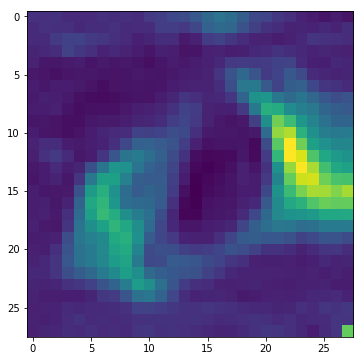

In [23]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), verbose=True)
plt.imshow(img[..., 0])

In this case, `ActivationMax Loss` is not bouncing bouncing around and converging? Perhaps we could get that loss to be lower by reducing weights of other losses that might be dominating the overall loss being minimized. 

The simplest way to tune these weights is to first start with `0.` weights for all regularization losses.

Iteration: 1, named_losses: [('ActivationMax Loss', 0.2693989)], overall loss: 0.269398897886
Iteration: 2, named_losses: [('ActivationMax Loss', -6.6923928)], overall loss: -6.69239282608
Iteration: 3, named_losses: [('ActivationMax Loss', -225.87207)], overall loss: -225.872070312
Iteration: 4, named_losses: [('ActivationMax Loss', -462.48257)], overall loss: -462.482574463
Iteration: 5, named_losses: [('ActivationMax Loss', -689.16077)], overall loss: -689.160766602
Iteration: 6, named_losses: [('ActivationMax Loss', -889.75427)], overall loss: -889.754272461
Iteration: 7, named_losses: [('ActivationMax Loss', -1073.9482)], overall loss: -1073.94824219
Iteration: 8, named_losses: [('ActivationMax Loss', -1242.8525)], overall loss: -1242.85253906
Iteration: 9, named_losses: [('ActivationMax Loss', -1402.7773)], overall loss: -1402.77734375
Iteration: 10, named_losses: [('ActivationMax Loss', -1558.7063)], overall loss: -1558.70629883
Iteration: 11, named_losses: [('ActivationMax Loss

Iteration: 90, named_losses: [('ActivationMax Loss', -9868.7793)], overall loss: -9868.77929688
Iteration: 91, named_losses: [('ActivationMax Loss', -9964.5371)], overall loss: -9964.53710938
Iteration: 92, named_losses: [('ActivationMax Loss', -10062.412)], overall loss: -10062.4121094
Iteration: 93, named_losses: [('ActivationMax Loss', -10158.876)], overall loss: -10158.8759766
Iteration: 94, named_losses: [('ActivationMax Loss', -10256.677)], overall loss: -10256.6767578
Iteration: 95, named_losses: [('ActivationMax Loss', -10352.661)], overall loss: -10352.6611328
Iteration: 96, named_losses: [('ActivationMax Loss', -10447.359)], overall loss: -10447.359375
Iteration: 97, named_losses: [('ActivationMax Loss', -10544.511)], overall loss: -10544.5107422
Iteration: 98, named_losses: [('ActivationMax Loss', -10640.197)], overall loss: -10640.1972656
Iteration: 99, named_losses: [('ActivationMax Loss', -10737.199)], overall loss: -10737.1992188
Iteration: 100, named_losses: [('Activati

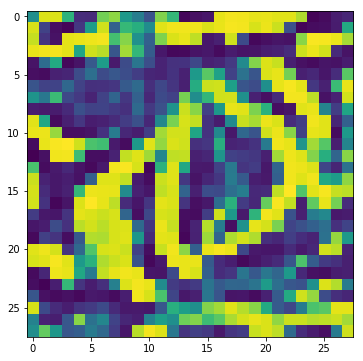

In [24]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                           tv_weight=0., lp_norm_weight=0., verbose=True)
plt.imshow(img[..., 0])

It does indeed go to much lower values, but the image looks less natural. Let's try varous range of total variation weights to enforce naturalness.

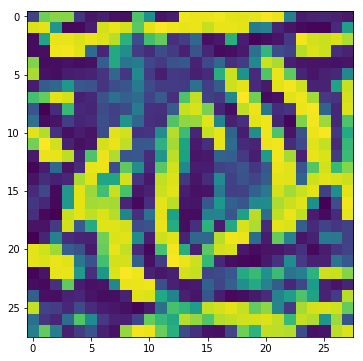

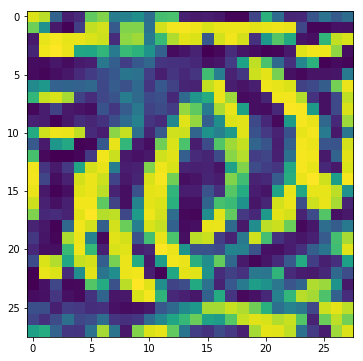

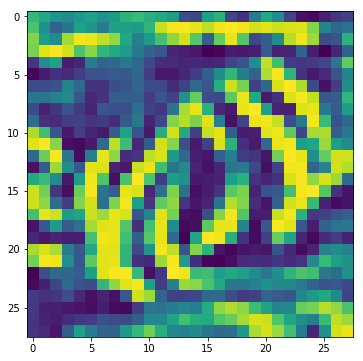

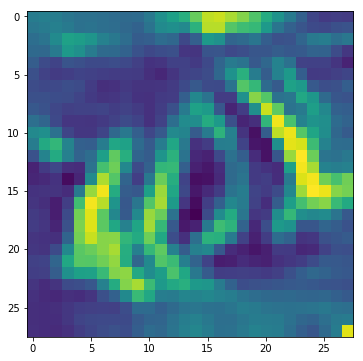

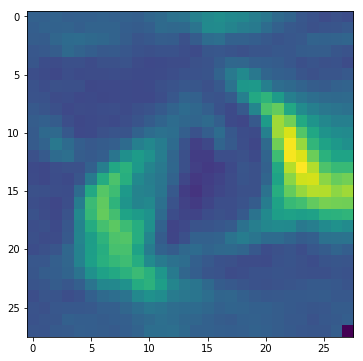

In [25]:
for tv_weight in [1e-3, 1e-2, 1e-1, 1, 10]:
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                               tv_weight=tv_weight, lp_norm_weight=0.)
    plt.figure()
    plt.imshow(img[..., 0])

We can see how total variation loss is enforcing blobbiness. In this case the default value of `tv_weight=10` seems to work very well. The point of this exercise was to show how weights can be tuned.

Lets visualize all other output categories and see what we get.

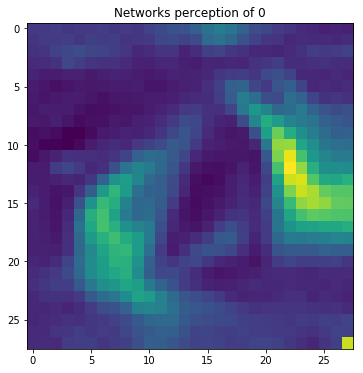

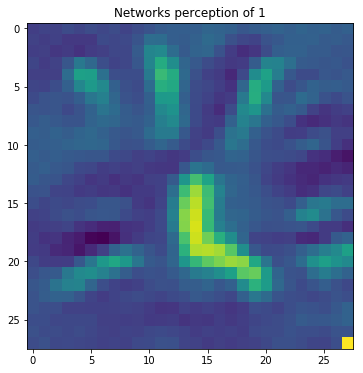

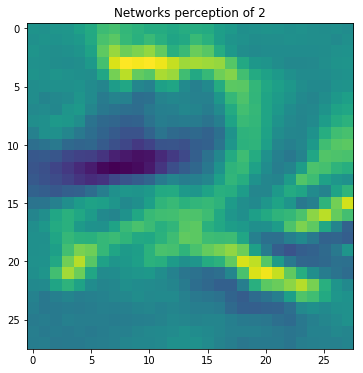

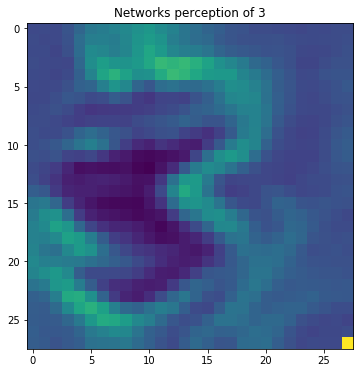

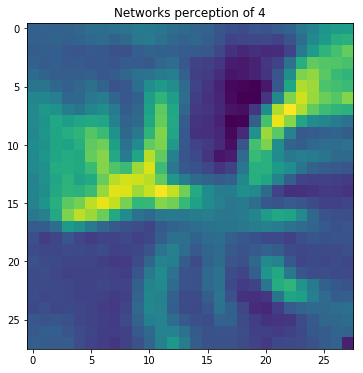

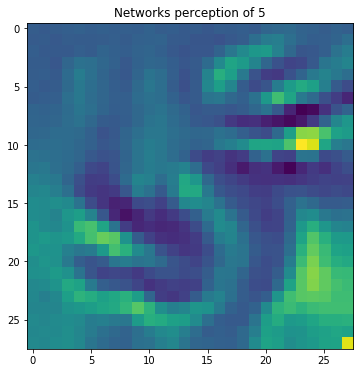

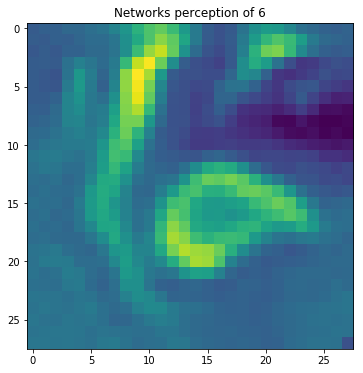

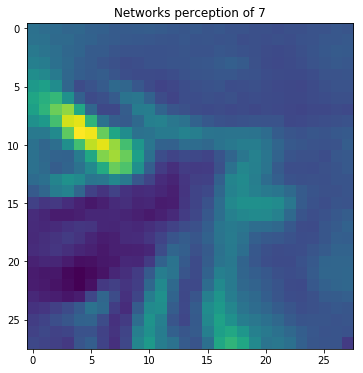

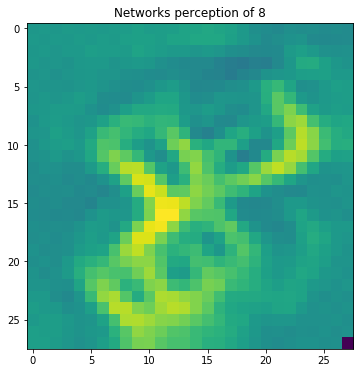

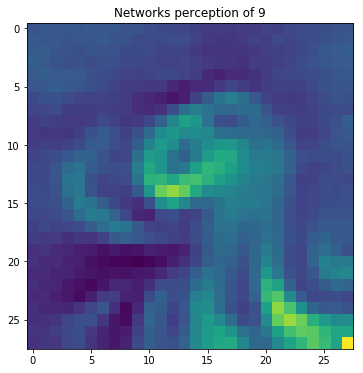

In [26]:
for output_idx in np.arange(10):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    plt.figure()
    plt.title('Networks perception of {}'.format(output_idx))
    plt.imshow(img[..., 0])

Pretty cool. Its amazing that we can even generate an input image via backprop! 

Obviously you can tune the visualizations to look better by experimenting with `image_modifiers`, lp-norm weight etc. Basically, a regularizer is needed to enforce image naturalness prior to limit the input image search space. By this point, GANs should come to your mind. We could easily take a GAN trained on mnist and use discriminator loss as a regularizer. For using custom loss, you can use `visualize_activation_with_losses` API.

Feel free to submit a PR if you try the GAN regularizer :)

## Other fun stuff

The API to `visualize_activation` accepts `filter_indices`. This is generally meant for *multi label* classifiers, but nothing prevents us from having some fun. 

By setting `filter_indices=[1, 7]`, we can generate an input that the network thinks is both 1 and 7 simultaneously. Its like asking the network

> Generate input image that you think is both 1 and a 7.

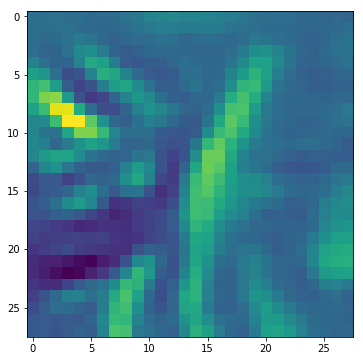

In [28]:
img = visualize_activation(model, layer_idx, filter_indices=[1, 7], input_range=(0., 1.))
plt.imshow(img[..., 0])

Compare this to the `1` generated above and you should be able to see the difference. Nifty indded!

## Visualizations without swapping softmax

As alluded at the beginning of the tutorial, we want to compare and see what happens if we didnt swap out softmax for linear activation.

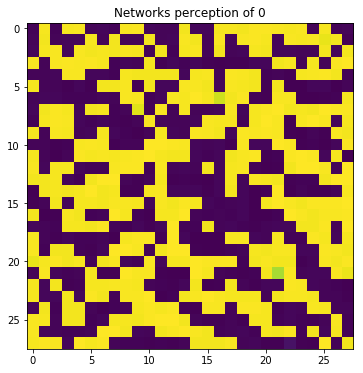

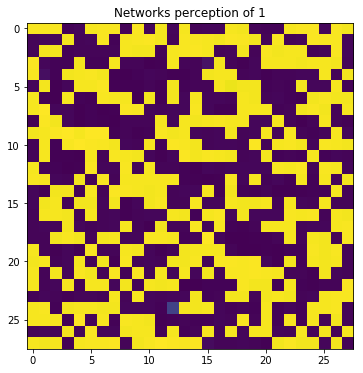

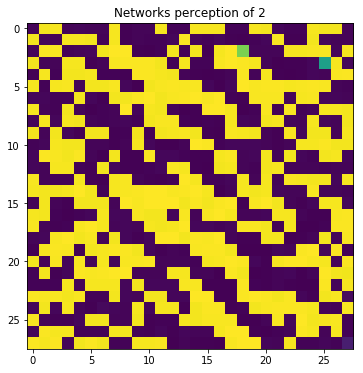

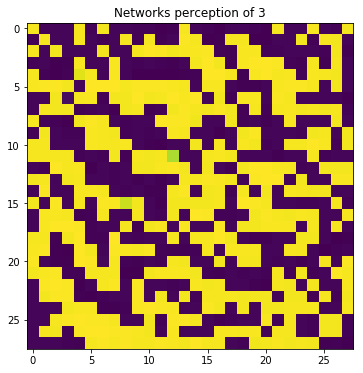

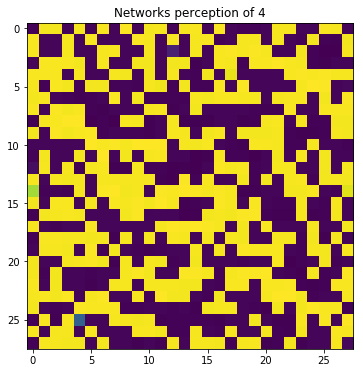

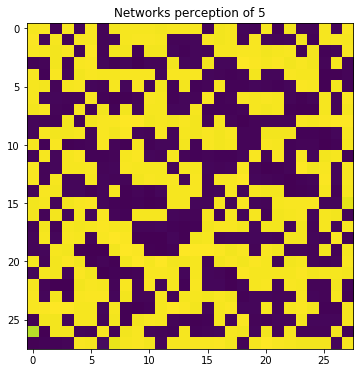

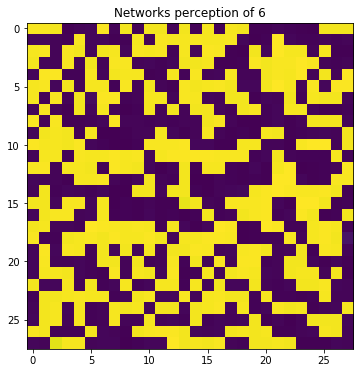

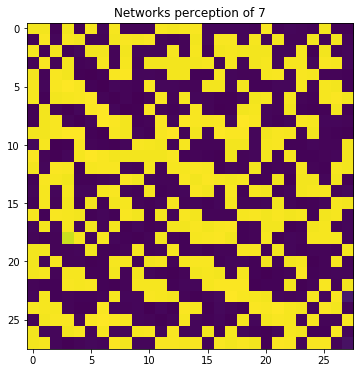

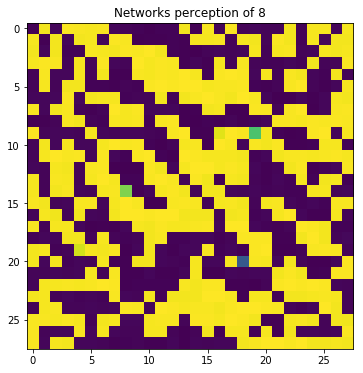

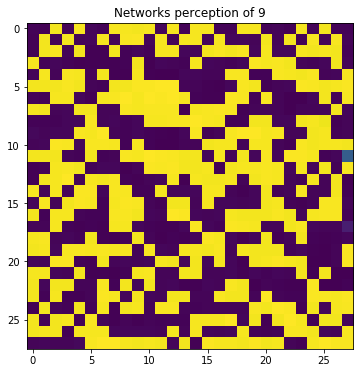

In [19]:
# Swap linear back with softmax
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)

for output_idx in np.arange(10):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    plt.figure()
    plt.title('Networks perception of {}'.format(output_idx))
    plt.imshow(img[..., 0])

It does not work! The reason is that maximizing an output node can be done by minimizing other outputs. Softmax is weird that way. It is the only activation that depends on other node output(s) in the layer.